## Final Project Submission

Please fill out:
* Student name: Stephen Bwanamkubwa
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Mr. William Okomba
* Blog post URL:


# INTRODUCTION

BUSINESS PROBLEM

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

IMPORTING ALL REQUIRED LIBRARIES HERE

Here we import all necessary Python libraries:

pandas, sqlite3: for data loading and manipulation data

matplotlib, seaborn: for data visualization

scipy.stats:for hypothesis testing and statistical analysis

numpy to create color scheme

In [32]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats



LOAD DATASETS

This section loads the datasets from the data folder.

All files are read into pandas dataframes and then combined for further analysis.

In [33]:
bom = pd.read_csv("data/bom.movie_gross.csv")
budgets = pd.read_csv("data/tn.movie_budgets.csv")
tmdb = pd.read_csv("data/tmdb.movies.csv")
rt_info = pd.read_csv("data/rt.movie_info.tsv", sep='\t')
rt_reviews = pd.read_csv("data/rt.reviews.tsv", sep='\t', encoding='latin1')

conn = sqlite3.connect("data/im.db")
movie_basics = pd.read_sql("SELECT * FROM movie_basics", conn)
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings", conn)
conn.close()

# DATA CLEANING


1.Convert our currency strings to numeric values

2.Handle missing and duplicate values in budgets, revenue, and ratings

3.Parse release dates and extract months

4.Normalize genre strings

making the dataset complete, accurate, and ready for analysis.

In [34]:
#1
budgets.drop_duplicates(subset=['movie'], inplace=True)
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    budgets[col] = budgets[col].replace('[\$,]', '', regex=True).astype(float)

#2
median_budget = budgets.loc[budgets['production_budget'] > 0, 'production_budget'].median()
median_gross = budgets.loc[budgets['worldwide_gross'] > 0, 'worldwide_gross'].median()
budgets['production_budget'] = budgets['production_budget'].fillna(median_budget)
budgets['worldwide_gross'] = budgets['worldwide_gross'].fillna(median_gross)
budgets['domestic_gross'] = budgets['domestic_gross'].fillna(0)

#3
budgets['release_date'] = pd.to_datetime(budgets['release_date'], errors='coerce')
budgets['release_month'] = budgets['release_date'].dt.month

# BOM cleaning
bom.drop_duplicates(subset=['title'], inplace=True)
for col in ['domestic_gross', 'foreign_gross']:
    bom[col] = bom[col].replace('[\$,]', '', regex=True)
    bom[col] = pd.to_numeric(bom[col], errors='coerce')
bom.dropna(subset=['domestic_gross'], inplace=True)

#tmdb cleaning 
tmdb.drop_duplicates(subset=['title'], inplace=True)

# rotten tomatoes cleaning
rt_info.drop_duplicates(subset=['id'], inplace=True)
rt_reviews.dropna(subset=['review'], inplace=True)

# numeric conversion and handling missigng values for IMDB database
movie_basics.drop_duplicates(subset=['primary_title'], inplace=True)
movie_basics['start_year'] = pd.to_numeric(movie_basics['start_year'], errors='coerce')
movie_basics['runtime_minutes'] = pd.to_numeric(movie_basics['runtime_minutes'], errors='coerce')
movie_basics['genres'] = movie_basics['genres'].fillna("Unknown")
movie_basics['genres'] = movie_basics['genres'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else x)


# renaming ratings column
if 'averagerating' in movie_ratings.columns:
    movie_ratings.rename(columns={'averagerating': 'average_rating'}, inplace=True)
elif 'average_rating' not in movie_ratings.columns:
    movie_ratings['average_rating'] = None

SENTIMENT ANALYSIS

In [35]:

def get_sentiment(text):
    text = str(text).lower()
    positive = ["good", "great", "excellent", "amazing", "love", "fantastic"]
    negative = ["bad", "poor", "terrible", "boring", "hate", "awful"]
    pos = sum(word in text for word in positive)
    neg = sum(word in text for word in negative)
    return "Positive" if pos > neg else ("Negative" if neg > pos else "Neutral")

rt_reviews['sentiment'] = rt_reviews['review'].apply(get_sentiment)
sentiment_summary = rt_reviews.groupby('id')['sentiment'].value_counts().unstack(fill_value=0)
sentiment_summary['positive_ratio'] = sentiment_summary['Positive'] / sentiment_summary.sum(axis=1)

DATASET MERGING

We merege allour data sets together so we can begin analysis


In [36]:
imdb_full = pd.merge(movie_basics, movie_ratings, on='movie_id', how='inner')
if 'average_rating' not in imdb_full.columns:
    imdb_full['average_rating'] = None

merged = pd.merge(budgets, imdb_full, left_on='movie', right_on='primary_title', how='left')
merged = pd.merge(merged, bom[['title', 'domestic_gross', 'foreign_gross']], 
                  left_on='movie', right_on='title', how='left')
merged = pd.merge(merged, tmdb[['title', 'popularity', 'vote_average']], 
                  left_on='movie', right_on='title', how='left')

rt_info['id'] = rt_info['id'].astype(str)
merged['movie'] = merged['movie'].astype(str)
merged = pd.merge(merged, rt_info[['id', 'genre', 'rating']].rename(columns={'id': 'rt_id'}),
                  left_on='movie', right_on='rt_id', how='left')

sentiment_summary.index = sentiment_summary.index.astype(str)
merged = pd.merge(merged, sentiment_summary[['positive_ratio']],
                  left_on='rt_id', right_index=True, how='left')

# Final cleanup
merged['production_budget'] = pd.to_numeric(merged['production_budget'], errors='coerce')
merged['worldwide_gross'] = pd.to_numeric(merged['worldwide_gross'], errors='coerce')
merged['domestic_gross_x'] = pd.to_numeric(merged.get('domestic_gross_x', 0), errors='coerce').fillna(0)
merged = merged[(merged['production_budget'] > 0) & (merged['worldwide_gross'] > 0)]


DATA ANALYSIS


We create visualizations to answer key business questions.

Revenue by Genre: Horizontal stacked bar chart comparing domestic and worldwide earnings (in billions)

ROI by Genre: Identifies which genres offer the best return on investment

Audience Ratings: Scatter plot showing correlation between ratings and revenue, plus a boxplot for genre-wise ratings

Release Timing: Bar chart showing how average revenue varies by release month

This is the color scheme used and default background in the graphs we plot. 

In [37]:
STAKEHOLDER_COLORS = {
    'domestic': '#003f5c',   # Navy Blue
    'worldwide': '#f2a900',  # Gold
    'roi': '#2ca02c',        # Emerald Green
    'ratings': '#7b1fa2',    # Deep Purple
    'box': '#9e9e9e'         # Silver Gray
}
sns.set_theme(style="whitegrid")


GENRE PERFORMANCE

This graph shows domestic and worldwide revenue distribution by movie genre in billions of dollars highlighting which genres are dominating the global box office.

<Figure size 1800x1400 with 0 Axes>

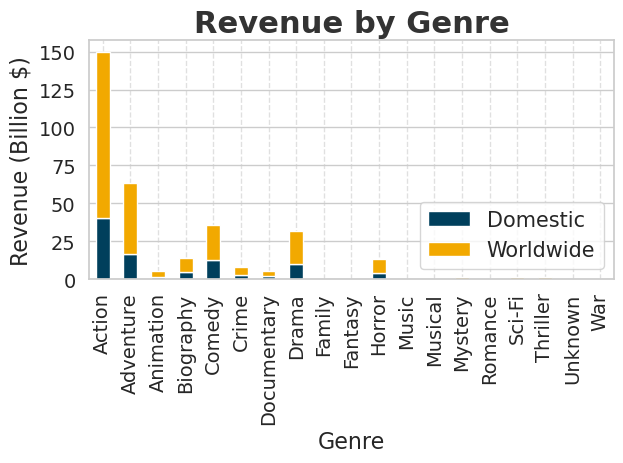

In [38]:
genre_revenue = merged.groupby('genres').agg({'domestic_gross_x': 'sum', 'worldwide_gross': 'sum'})
genre_revenue = genre_revenue / 1_000_000_000

if not genre_revenue.empty:
    plt.figure(figsize=(18,14))
    genre_revenue.plot(kind='bar', stacked=True, color=[STAKEHOLDER_COLORS['domestic'], STAKEHOLDER_COLORS['worldwide']])
    plt.title("Revenue by Genre", fontsize=22, weight='bold', color='#333333')
    plt.xlabel("Genre", fontsize=16)
    plt.ylabel("Revenue (Billion $)", fontsize=16)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.legend(["Domestic", "Worldwide"], fontsize=15, loc='lower right')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.tight_layout()
    plt.savefig('visuals/revenue_by_genre.png')
    plt.show()

ROI BY GENRE

This graph shows the average return on investment for each genre.
Higher ROI genres indicate better profitability relative to production costs.

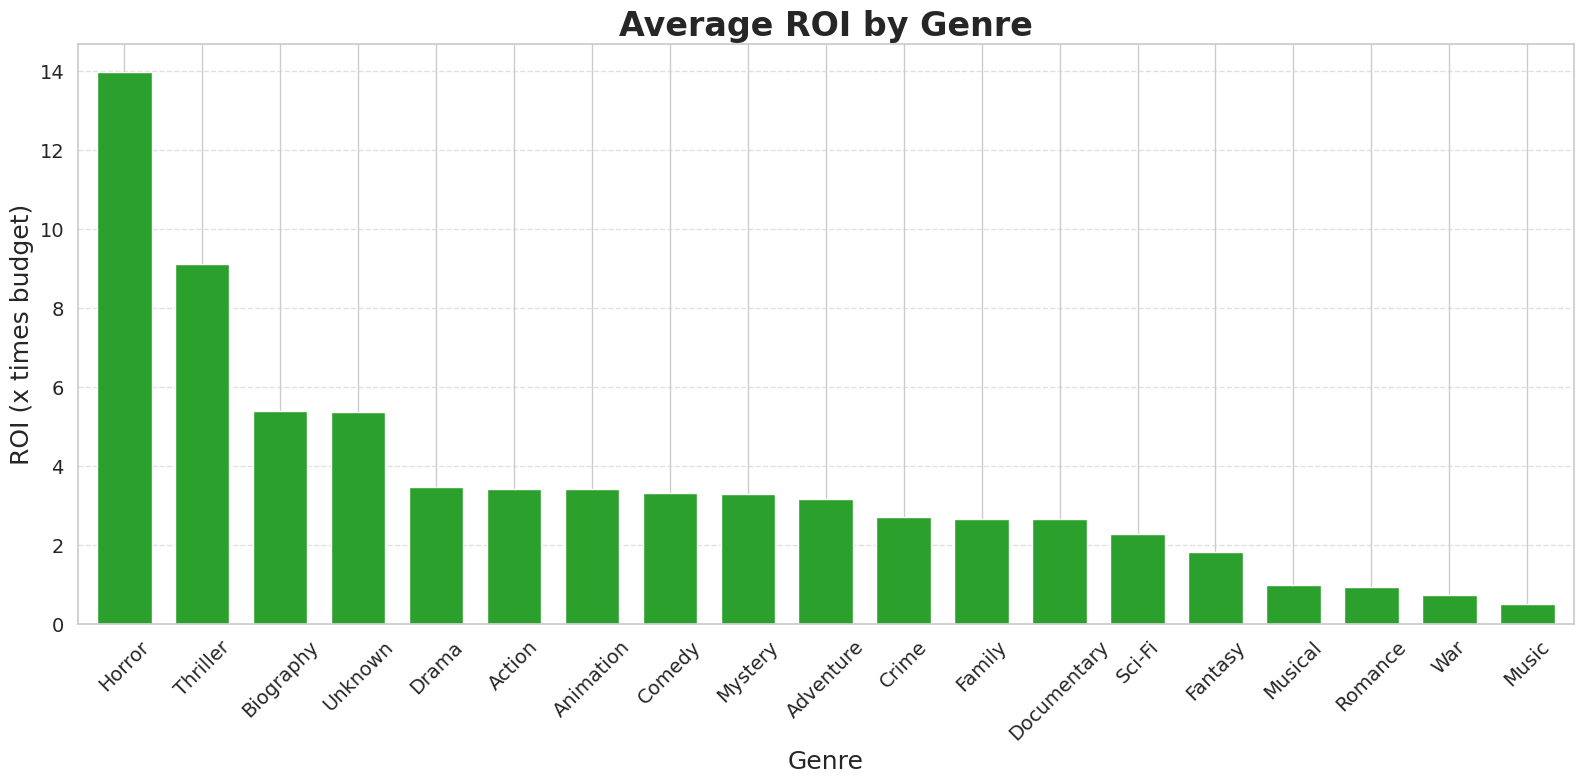

In [39]:
merged['ROI'] = merged['worldwide_gross'] / merged['production_budget']
roi_genre = merged.groupby('genres')['ROI'].mean().sort_values(ascending=False)

if not roi_genre.empty:
    plt.figure(figsize=(16,8))
    roi_genre.plot(kind='bar', color=STAKEHOLDER_COLORS['roi'], width=0.7)
    plt.title("Average ROI by Genre", fontsize=24, weight='bold')
    plt.ylabel("ROI (x times budget)", fontsize=18)
    plt.xlabel("Genre", fontsize=18)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.tight_layout()
    plt.savefig('visuals/roi_by_genre.png')
    plt.show()

AUDIENCE RATINGS VS WORLDWIDE GROSS

This scatter plot depicts the relationship between average audience ratings and worldwide revenue.
It helps evaluate whether higher ratings translate to higher earnings.

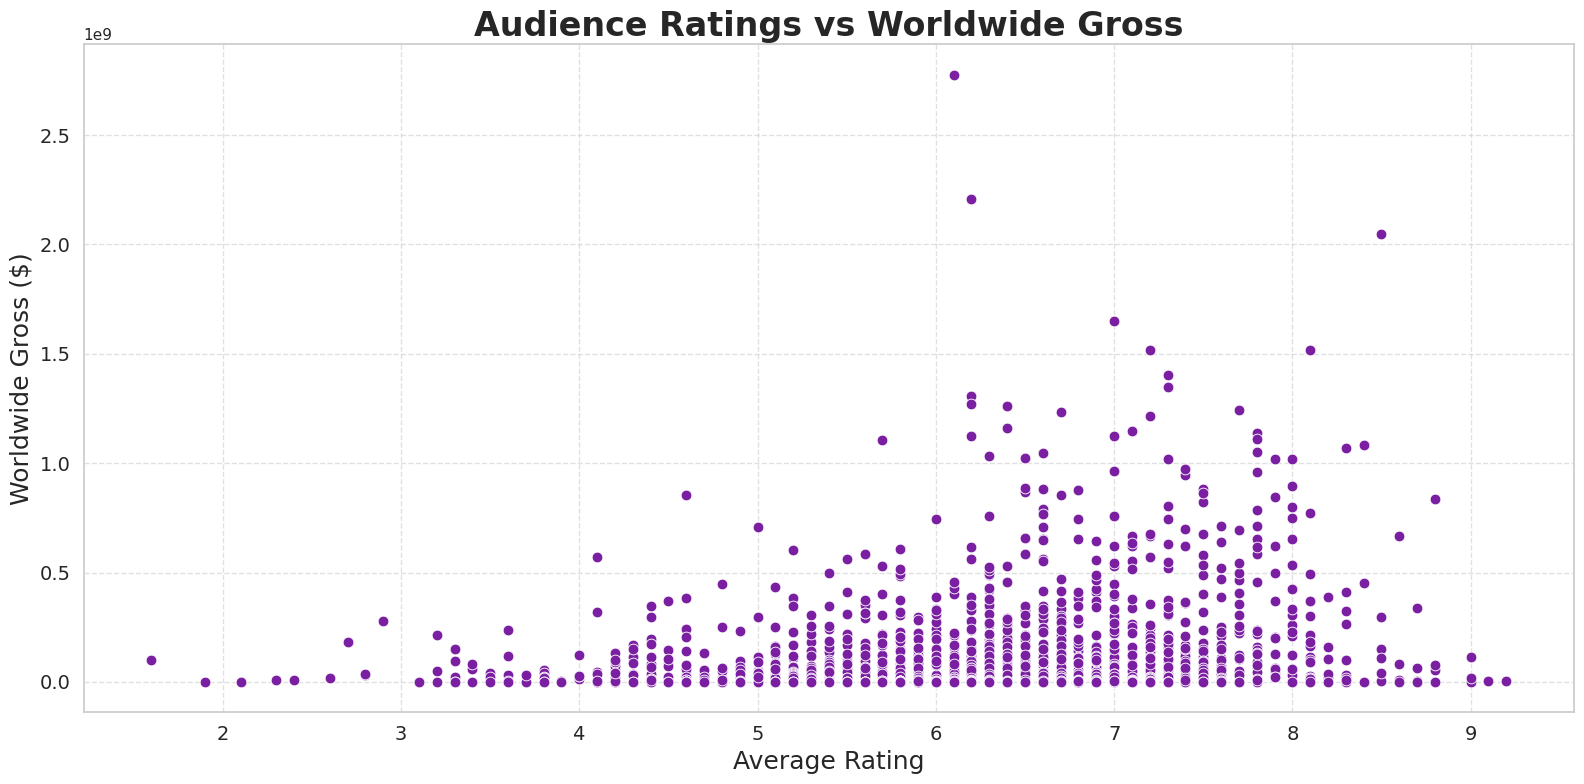

In [40]:

plt.figure(figsize=(16,8))
sns.scatterplot(x='average_rating', y='worldwide_gross', 
                data=merged, color=STAKEHOLDER_COLORS['ratings'], s=60)
plt.title("Audience Ratings vs Worldwide Gross", fontsize=24, weight='bold')
plt.xlabel("Average Rating", fontsize=18)
plt.ylabel("Worldwide Gross ($)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.tight_layout()
plt.savefig('visuals/ratings_vs_gross.png')
plt.show()


AUDIENCE RATING BY GENRE (boxplot)

This boxplot shows the distribution of audience ratings for each genre.
It identifies which genres have consistently high or low ratings.

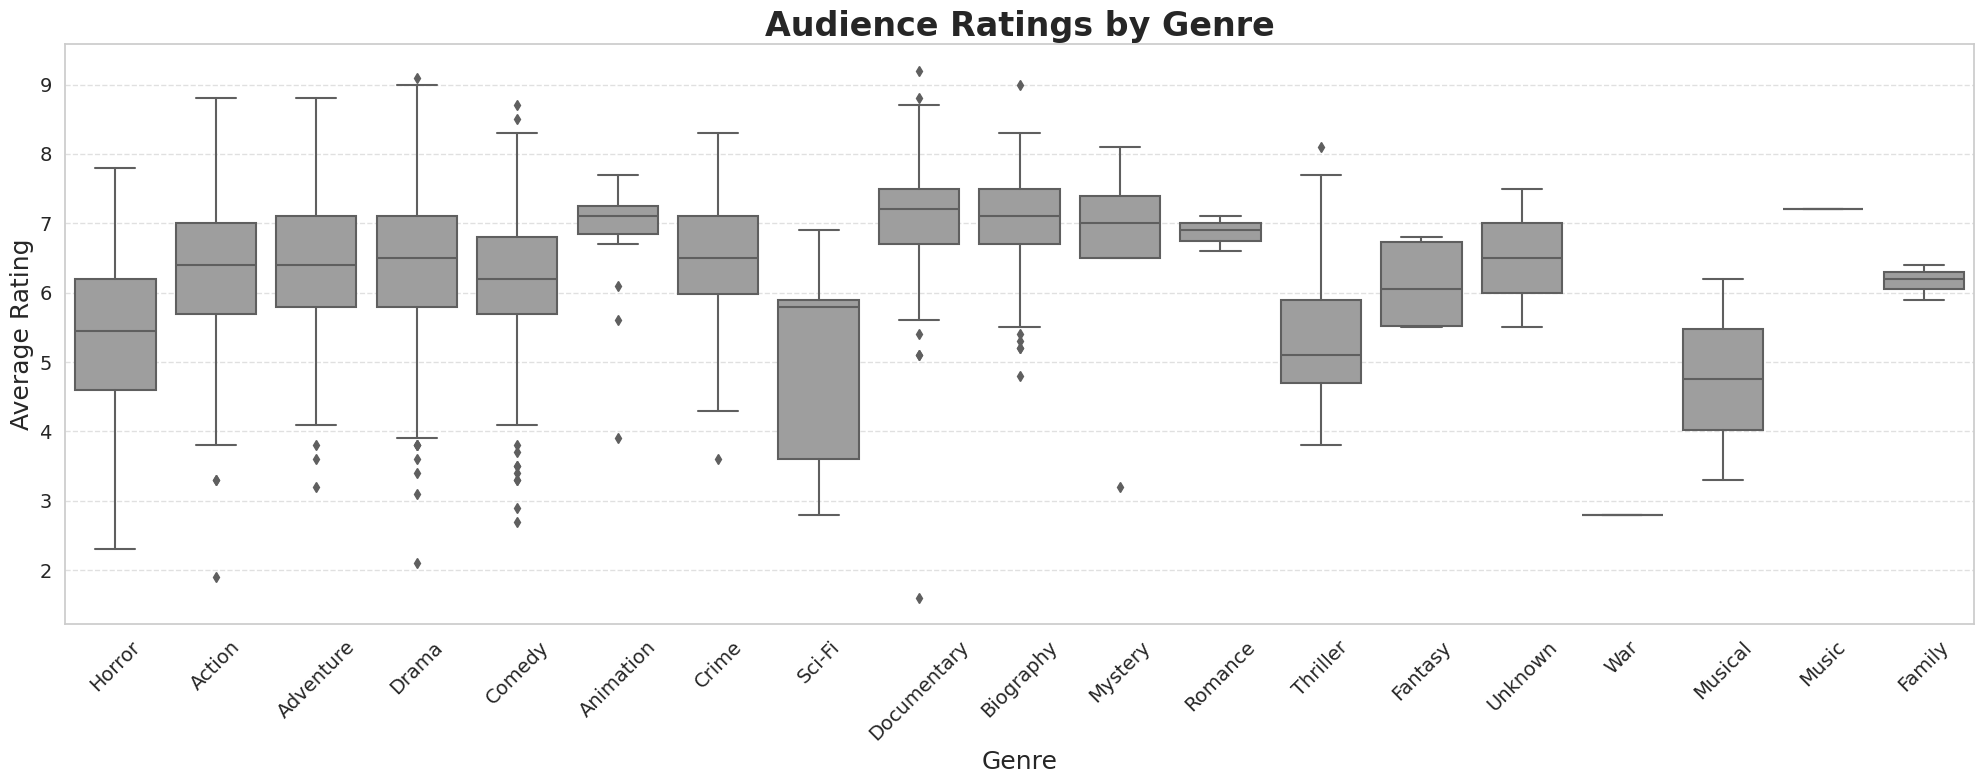

In [41]:

plt.figure(figsize=(20,8))
sns.boxplot(x='genres', y='average_rating', data=merged, 
            color=STAKEHOLDER_COLORS['box'])
plt.title("Audience Ratings by Genre", fontsize=24, weight='bold')
plt.xlabel("Genre", fontsize=18)
plt.ylabel("Average Rating", fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('visuals/ratings_by_genre.png')
plt.show()

RELEASE TIMING

This bar chart compares the average worldwide revenue across release months.
It highlights peak earning periods for strategic release planning.

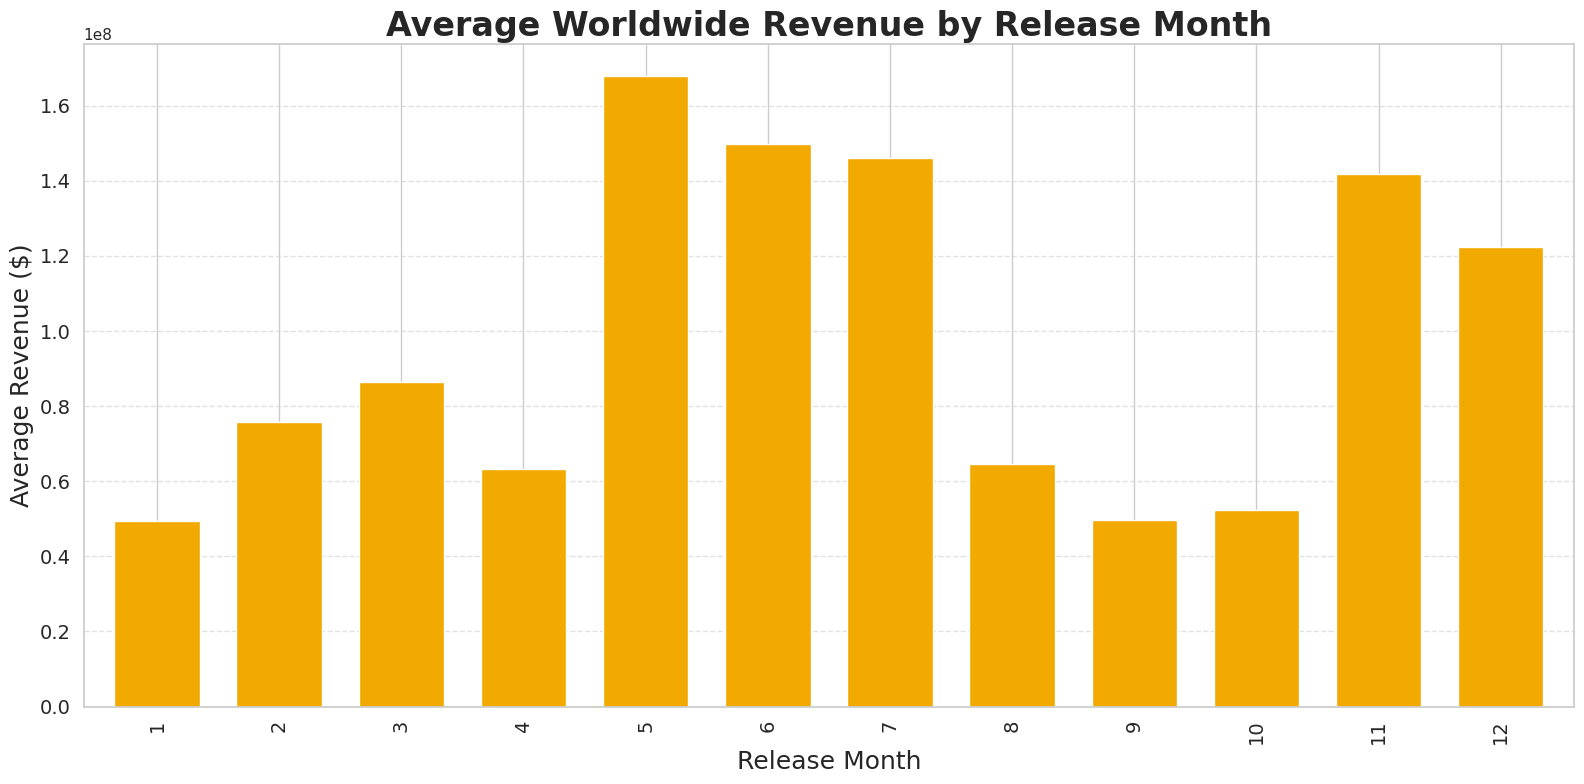

In [42]:

merged['release_month'] = pd.to_datetime(merged['release_date'], errors='coerce').dt.month
month_revenue = merged.groupby('release_month')['worldwide_gross'].mean()

if not month_revenue.empty:
    plt.figure(figsize=(16,8))
    month_revenue.plot(kind='bar', color=STAKEHOLDER_COLORS['worldwide'], width=0.7)
    plt.title("Average Worldwide Revenue by Release Month", fontsize=24, weight='bold')
    plt.ylabel("Average Revenue ($)", fontsize=18)
    plt.xlabel("Release Month", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('visuals/revenue_by_month.png')
    plt.show()


# Hypothesis Testing

We perform statistical analyses to validate insights:

1. ANOVA ROI by Genre: Groups ROI values by genre and checks if differences are statistically significant.

2. ANOVA Ratings by Genre: Tests whether average ratings significantly differ across genres.

3. Pearson Correlation: Measures the strength of relationship between average ratings and worldwide gross.

4. ANOVA Revenue by Month: Determines if average worldwide gross varies significantly by release month.


Results provide statistical evidence to support strategic decisions.

In [43]:

# 1
roi_groups = [group['ROI'].dropna() for name, group in merged.groupby('genres')]
f_val_roi, p_val_roi = stats.f_oneway(*roi_groups)
print(f"ANOVA ROI by Genre: F={f_val_roi:.3f}, p={p_val_roi:.4f}")

# 2
rating_groups = [group['average_rating'].dropna() for name, group in merged.groupby('genres')]
f_val_rating, p_val_rating = stats.f_oneway(*rating_groups)
print(f"ANOVA Ratings by Genre: F={f_val_rating:.3f}, p={p_val_rating:.4f}")

#3
corr_data = merged.dropna(subset=['average_rating', 'worldwide_gross'])
corr, pval_corr = stats.pearsonr(corr_data['average_rating'], corr_data['worldwide_gross'])
print(f"Correlation Ratings vs Worldwide Gross: r={corr:.3f}, p={pval_corr:.4f}")

# 4
month_groups = [group['worldwide_gross'].dropna() for name, group in merged.groupby('release_month')]
f_val_month, p_val_month = stats.f_oneway(*month_groups)
print(f"ANOVA Revenue by Month: F={f_val_month:.3f}, p={p_val_month:.4f}")




ANOVA ROI by Genre: F=3.132, p=0.0000
ANOVA Ratings by Genre: F=13.400, p=0.0000
Correlation Ratings vs Worldwide Gross: r=0.193, p=0.0000
ANOVA Revenue by Month: F=28.453, p=0.0000


# A/B Testing

We simulate controlled comparisons:

Peak vs Off-Peak Release Months: Tests if seasonal timing significantly affects revenue.

High vs Low Budget Films: Checks whether higher budgets significantly impact ROI.

These tests help determine if release timing or budget size significantly affect revenue and ROI.

In [44]:
# peak vs off-peak release months
merged['peak_season'] = merged['release_month'].apply(lambda x: 'Peak' if x in [5, 6, 7, 11, 12] else 'Off-Peak')
peak = merged[merged['peak_season'] == 'Peak']['worldwide_gross'].dropna()
off_peak = merged[merged['peak_season'] == 'Off-Peak']['worldwide_gross'].dropna()
t_stat, p_val = stats.ttest_ind(peak, off_peak, equal_var=False)
print(f"A/B Test: Peak vs Off-Peak Release Months: t={t_stat:.3f}, p={p_val:.4f}")

# high vs low budget films
median_budget = merged['production_budget'].median()
merged['budget_group'] = merged['production_budget'].apply(lambda x: 'High' if x >= median_budget else 'Low')
high_budget_roi = merged[merged['budget_group'] == 'High']['ROI'].dropna()
low_budget_roi = merged[merged['budget_group'] == 'Low']['ROI'].dropna()
t_stat, p_val = stats.ttest_ind(high_budget_roi, low_budget_roi, equal_var=False)
print(f"A/B Test: High vs Low Budget Films: t={t_stat:.3f}, p={p_val:.4f}")

A/B Test: Peak vs Off-Peak Release Months: t=15.459, p=0.0000
A/B Test: High vs Low Budget Films: t=-5.428, p=0.0000


# Conclusion & Recommendations



After a comprehensive analysis of multiple movie datasets, our investigation has provided clear, data-driven insights for establishing what genre of films to create.

Most dominant genre: Action, Adventure, and Animation films dominate worldwide gross, while Horror and Thriller genres deliver exceptionally high ROI despite having lower budgets.

Audience Ratings: There is only a weak positive correlation between ratings and revenue, suggesting that marketing and timing can outweigh critical reviews.

Seasonal Advantage: Movies released during summer and holiday seasons significantly outperform off-peak releases in global earnings.

Budget Efficiency: Lower-budget films generally achieve higher ROI than high-budget productions, indicating opportunities for maximizing profits with smaller production costs.


Final Recommendation

For a new movie studio to enter the market successfully, it should:

1. Prioritize high-ROI genres like Horror and Thriller for steady profits.

2. Produce its big-budget Action/Adventure titles for global audiences during peak release windows.

3. Avoid over-reliance on high budgets, instead leveraging efficient production and data-driven marketing.

4. Use ROI-based decision-making for budget allocations rather than solely relying on audience ratings.

By following these insights, the studio can confidently compete with established players, achieve sustainable profitability, and position itself for long-term success in the global film industry.